In [1]:
#@title get model coordinates
import plotly.express as px
import pandas as pd
import numpy as np

coor = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/distan_lat42.58lon-8.8046p3R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [16]:
#@title get station sample mean wind speed hour before (Beaufort)
from pandas.core.arrays import categorical
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/station.csv", usecols = ["time","spd_o"],parse_dates=["time"]).set_index("time")
#print("raw data\n",station.head(24))

#show duplicated
df_duplicate = station[station.index.duplicated()]
#print("duplicated")
#print(df_duplicate)

#delete duplicated and resample
station = station[~station.index.duplicated(keep='first')]
station = station.resample("H",label="right",closed="right").mean()

#label
#dir udr to interval
labels = ["F0","F1","F2","F3","F4","F5","F6","F7","F8","F9","F10","F11","F12"]
interval = pd.IntervalIndex.from_tuples([(-1, 0.5), (.5, 1.5), (1.5, 3.3),(3.3,5.5),
                                     (5.5,8),(8,10.7),(10.7,13.8),(13.8,17.1),
                                     (17.1,20.7),(20.7,24.4),(24.4,28.4),(28.4,32.6),(32.6,60)])

station["spd_o_l"] = pd.cut(station["spd_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
station = station.drop(["spd_o"],axis=1)
print("Climatology %")
round(station["spd_o_l"].value_counts(normalize=True),2)


Climatology 


F3     0.23
F2     0.22
F4     0.21
F1     0.14
F5     0.13
F0     0.04
F6     0.03
F7     0.00
F8     0.00
F9     0.00
F10    0.00
F11    0.00
F12    0.00
Name: spd_o_l, dtype: float64

In [3]:
#@title Get meteorologic model d0
#ria forecast d0
met_model = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/lat42.58lon-8.8046p3R4KmD0.csv",parse_dates=["time"]).drop(columns=["Unnamed: 0"]).set_index("time")
met_model.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42021 entries, 2018-01-01 01:00:00 to 2023-01-01 23:00:00
Data columns (total 75 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dir0         42021 non-null  float64
 1   snow_prec0   42021 non-null  float64
 2   snowlevel0   42021 non-null  float64
 3   mod0         42021 non-null  float64
 4   wind_gust0   42021 non-null  float64
 5   mslp0        42021 non-null  float64
 6   temp0        42021 non-null  float64
 7   rh0          42021 non-null  float64
 8   visibility0  42021 non-null  float64
 9   lhflx0       42021 non-null  float64
 10  lwflx0       42021 non-null  float64
 11  conv_prec0   42021 non-null  float64
 12  prec0        42021 non-null  float64
 13  swflx0       42021 non-null  float64
 14  shflx0       42021 non-null  float64
 15  cape0        42021 non-null  float64
 16  cin0         42021 non-null  float64
 17  cfh0         42021 non-null  float64
 18  cfl0       

In [4]:
#@title Concatenate station and meteorological model and drop nan
df_all = pd.concat([station,met_model],axis=1).dropna()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41378 entries, 2018-01-01 01:00:00 to 2022-12-30 23:00:00
Data columns (total 76 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   spd_o_l      41378 non-null  category
 1   dir0         41378 non-null  float64 
 2   snow_prec0   41378 non-null  float64 
 3   snowlevel0   41378 non-null  float64 
 4   mod0         41378 non-null  float64 
 5   wind_gust0   41378 non-null  float64 
 6   mslp0        41378 non-null  float64 
 7   temp0        41378 non-null  float64 
 8   rh0          41378 non-null  float64 
 9   visibility0  41378 non-null  float64 
 10  lhflx0       41378 non-null  float64 
 11  lwflx0       41378 non-null  float64 
 12  conv_prec0   41378 non-null  float64 
 13  prec0        41378 non-null  float64 
 14  swflx0       41378 non-null  float64 
 15  shflx0       41378 non-null  float64 
 16  cape0        41378 non-null  float64 
 17  cin0         41378 non-null  float

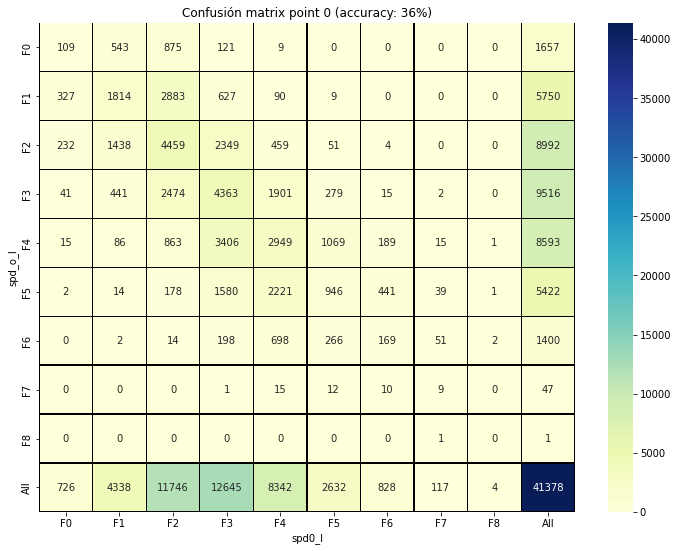

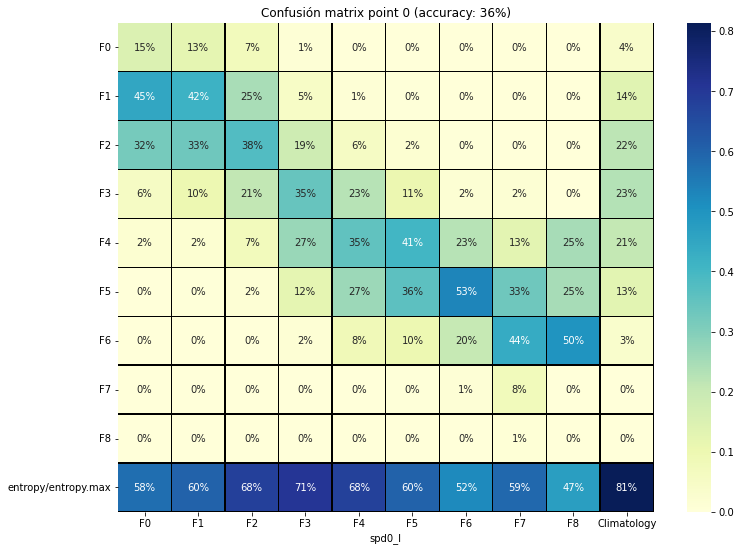

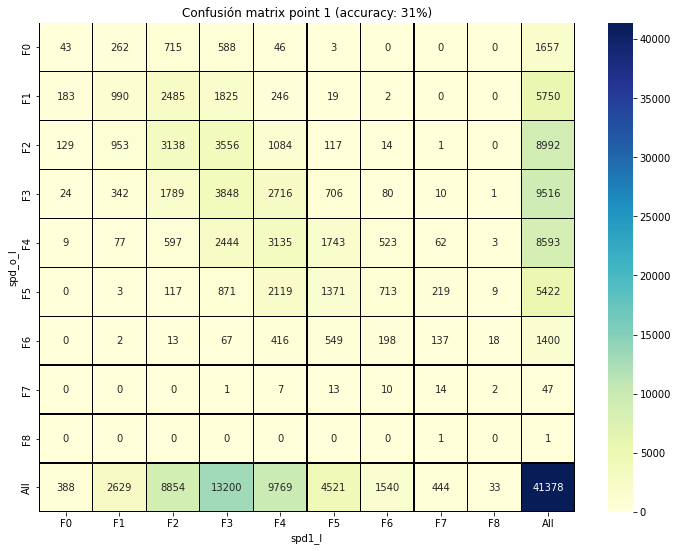

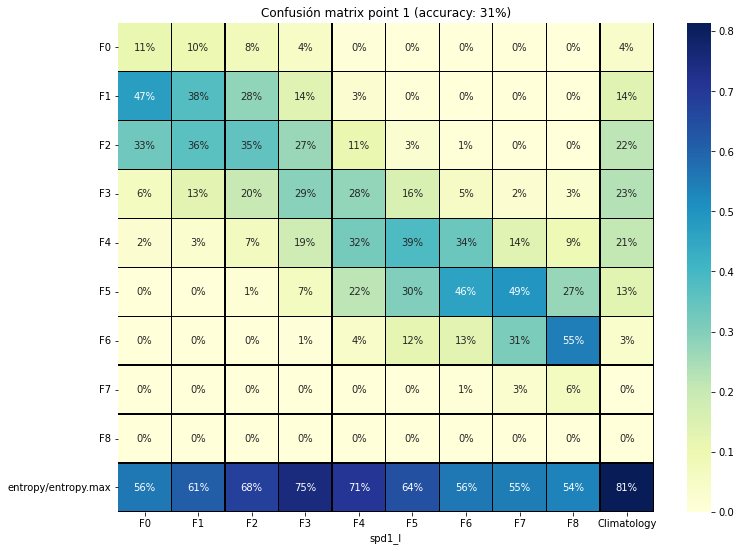

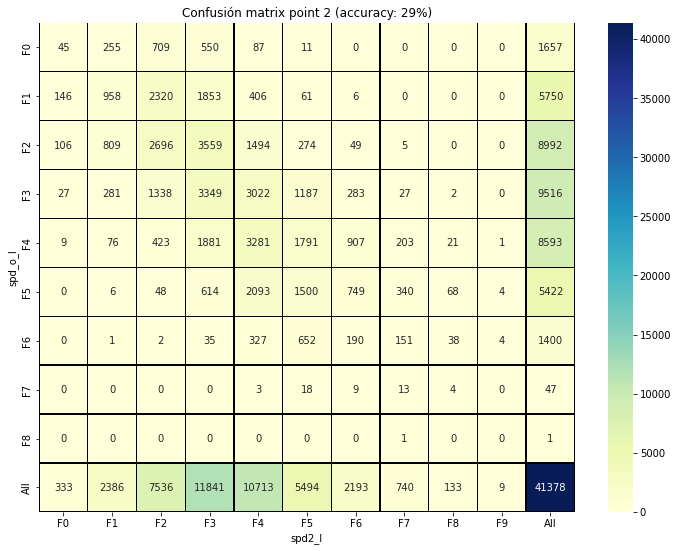

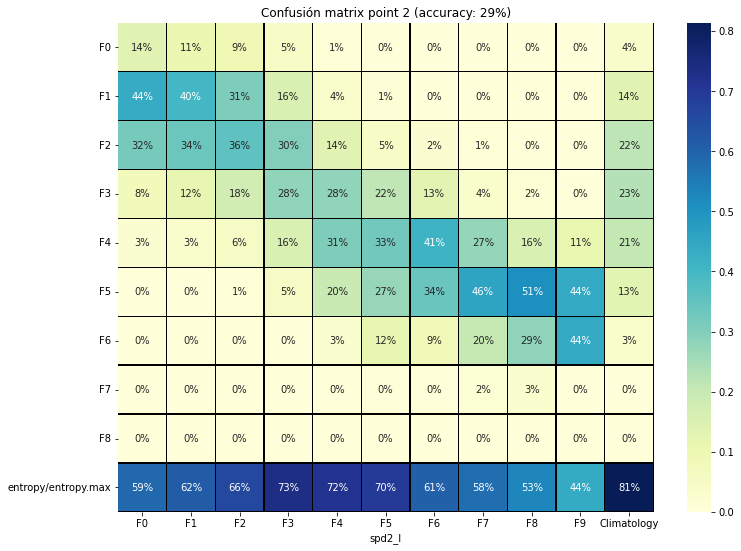

In [10]:
#@title Compare meteorological model variables mod1, mod2 and mod3 versus spd_o_l from the station
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import entropy

#label dir 0,1 and 2
df_all["spd0_l"] = pd.cut(df_all["mod0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["spd1_l"] = pd.cut(df_all["mod1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["spd2_l"] = pd.cut(df_all["mod2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')

acc0 = accuracy_score(df_all.spd_o_l, df_all.spd0_l)
acc1 = accuracy_score(df_all.spd_o_l, df_all.spd1_l)
acc2 = accuracy_score(df_all.spd_o_l, df_all.spd2_l)

#point 0
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc0))
global_sc = pd.crosstab(df_all.spd_o_l, df_all.spd0_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc0))
column_sc = pd.crosstab(df_all.spd_o_l, df_all.spd0_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#point 1
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 1 (accuracy: {:.0%})".format(acc1))
global_sc = pd.crosstab(df_all.spd_o_l, df_all.spd1_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 1 (accuracy: {:.0%})".format(acc1))
column_sc = pd.crosstab(df_all.spd_o_l, df_all.spd1_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#point 3
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 2 (accuracy: {:.0%})".format(acc2))
global_sc = pd.crosstab(df_all.spd_o_l, df_all.spd2_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 2 (accuracy: {:.0%})".format(acc2))
column_sc = pd.crosstab(df_all.spd_o_l, df_all.spd2_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


#delete met model label columns
df_all = df_all.drop(["spd0_l","spd1_l","spd2_l"],axis=1)

In [12]:
#@title Add time variables. Train machine learning and results
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.spd_o_l
X = df_all[["wind_gust0","mod0","dir0","wind_gust1","mod1","dir1","wind_gust2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]

acc_t = []
for t in range (0,20):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  ml_model = LGBMClassifier(n_estimators=200).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc_t.append(round(accuracy_score(y_test,y_pred),2))
  print("machine learning number:",t)
  
 
print("Accuracy Machine learning models")
df_r=pd.DataFrame({"acc_t":acc_t,});
df_r.describe()



machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
machine learning number: 10
machine learning number: 11
machine learning number: 12
machine learning number: 13
machine learning number: 14
machine learning number: 15
machine learning number: 16
machine learning number: 17
machine learning number: 18
machine learning number: 19
Accuracy Machine learning models


,acc_t
count,20.0000
mean,0.4495
std,0.0394
min,0.4000
25%,0.4200
50%,0.4400
75%,0.4750
max,0.5200


Accuracy machine learning models:
 [0.42, 0.5, 0.45, 0.43, 0.41, 0.42, 0.49, 0.45, 0.41, 0.46, 0.4, 0.52, 0.42, 0.47, 0.44, 0.52, 0.41, 0.51, 0.44, 0.42]
*************************************



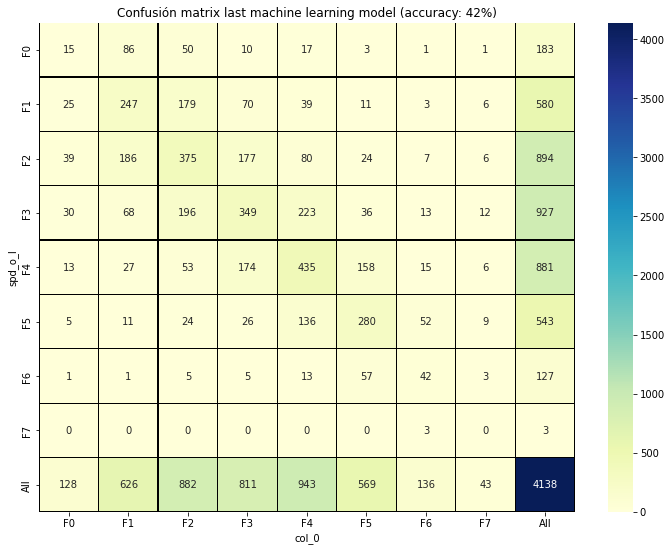

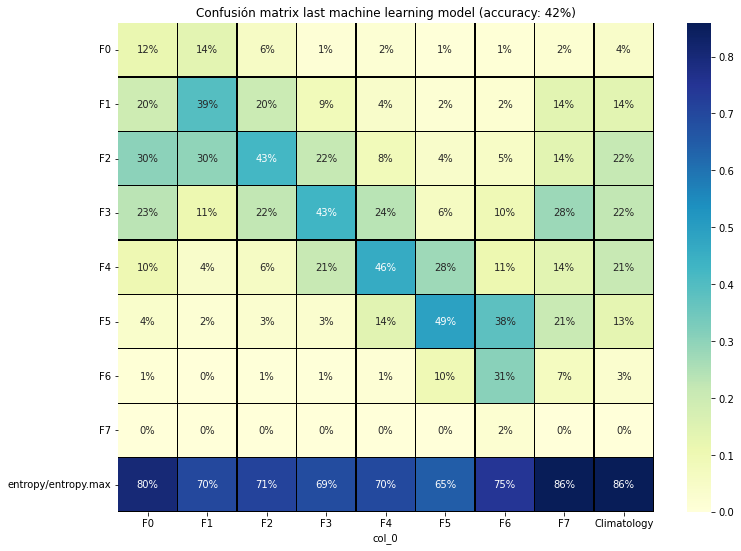

In [19]:
#@title Show machine learning results

print("Accuracy machine learning models:\n",acc_t)
print("*************************************\n")
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_t[-1]))
global_sc = pd.crosstab(y_test, y_pred, margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');


plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_t[-1]))
column_sc = pd.crosstab(y_test, y_pred, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

In [14]:
#@title Save algorithm
import pickle
from sklearn.pipeline import Pipeline


estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)
print(pipe)
al_file={"x_var":X.columns,"coor":coor,"pipe":pipe}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/Coron/algorithms/spd_coron_d0.al", 'wb'))

Pipeline(steps=[('ml_model', LGBMClassifier(n_estimators=200))])
